# Abnormal wafer detection in semi-conductor production

The purpose of this notebook is to show the use of the FreshQ library in a setting which is unlikely to be influenced by the behaviour of a large number of outside human influences as is the case in the bike rental and stock market examples.

In the case presented here the goal is to detect given a time series of features for each wafer if the wafer will be normal/abnormal i.e if the wafer will need to be removed from the manufacturing pipeline at some later point or meets the requirements of the manufacturer.

The data used here has been loaded and processed post download into its current form from https://www.cs.cmu.edu/~bobski/data/data.html 

## Load libraries and data

Provided the ml library is placed in $QHOME, the following cell will load all required functions contained in the `.fresh` namespace in the fresh.q library and any preprocessing/statistical or graphical functions used which are contained in the `.ml` namespace within the mlutils folder

In [1]:
\l ml/init.q
\l graphics.q

In [2]:
data: ("SIIIIIII"; enlist ",") 0:`:SampleDatasets/waferdata.csv
targets:("SI";enlist ",") 0:`:SampleDatasets/wafertargets.csv

Given that this data does not contain null values and is spaced with equi-time there is no requirement for the time column within the data as such this can be deleted

In [3]:
10#data:delete time from data

id      feat11 feat12 feat15 feat6 feat7 feat8
----------------------------------------------
1549_01 2      -11    -1     3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     25    477  
1549_01 2      -11    0      3     24    499  
1549_01 2      -11    0      3     25    1542 
1549_01 2      -11    0      3     24    1869 
1549_01 2      -11    0      3     24    2234 
1549_01 2      -11    0      3     25    2259 


The following shows the distribution of the targets within the initial dataset

In [4]:
target:targets`target
update pcnt:100*num%sum num from select num:count i by target from ([]target:target)

target| num  pcnt    
------| -------------
0     | 127  10.63652
1     | 1067 89.36348


## Feature Extraction and selection

In [5]:
/ In this example we are only concerned with producing features which require as input the time series data 
singleinput:.ml.fresh.getsingleinputfeatures[]
/ Produce features based on the unique id's of the data set without using the id column as for feature extraction
5#createdfeatures:.ml.fresh.createfeatures[data;`id;1_cols data;singleinput]

id     | absenergy_feat11 absenergy_feat12 absenergy_feat15 absenergy_feat6 a..
-------| --------------------------------------------------------------------..
1549_01| 1.666914e+08     8.405464e+07     971495           3.025968e+07    1..
1549_02| 1.680301e+08     8.206528e+07     937086           3.081874e+07    1..
1549_04| 1.548667e+08     7.124947e+07     580387           3.04597e+07     9..
1549_06| 1.609981e+08     8.847354e+07     981203           3.041265e+07    1..
1549_07| 1.671974e+08     7.242925e+07     828451           3.082033e+07    1..


In [6]:
/ Complete feature significance tests on the dataset to only use features deemed to be important to target prediction
5#sigfeattab:key[createdfeatures]!.ml.fresh.significantfeatures[value createdfeatures;targets[`target]]

id     | absenergy_feat11 absenergy_feat12 absenergy_feat15 absenergy_feat6 a..
-------| --------------------------------------------------------------------..
1549_01| 1.666914e+08     8.405464e+07     971495           3.025968e+07    2..
1549_02| 1.680301e+08     8.206528e+07     937086           3.081874e+07    2..
1549_04| 1.548667e+08     7.124947e+07     580387           3.04597e+07     2..
1549_06| 1.609981e+08     8.847354e+07     981203           3.041265e+07    2..
1549_07| 1.671974e+08     7.242925e+07     828451           3.082033e+07    2..


The following shows that the number of features deemed to be important to the prediction of abnormalities in the manufacturing of the semiconductor wafers is less than the total number of features produced through the `.fresh.createfeatures` procedure

In [7]:
-1"The number of extracted features from the dataset is: ",string count cols createdfeatures;
-1"The number of features deemed significant to prediction is: ",string count cols sigfeattab;

The number of extracted features from the dataset is: 217
The number of features deemed significant to prediction is: 146


### Preparing the data for Machine Learning

In [8]:
/ Convert the table containing significant features to a matrix in order to allow it to be passed to a machine learning algorithm
featmat:.ml.mattab[value sigfeattab]

/ Set a benchmark to be compared against, in this case we use the average value for each feature on each id
benchmark:select avg feat11,avg feat12,avg feat15,avg feat6,avg feat7,avg feat8 by id from data
benchmarktest:.ml.mattab[value benchmark]

## Initiate machine learning algorithm

In [9]:
k:rand 1000
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 500;`random_state pykw k;`verbose pykw 1]
classreport:.p.import[`sklearn.metrics]`:classification_report

## Train the model

Here we train the machine learning model for the same split of the data and the same random forest classifier to test that the application of the feature extraction and feature significance tests have been informative to the prediction of the final state of the wafer post production. These can also be compared to the naive case where the assumption is that all wafers being produced are deemed to be normal.

In [10]:
seed:"i"$.z.t
dict1:.ml.traintestsplitseed[featmat;targets[`target];0.2;seed];

clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`

print classreport[dict1[`ytest];pred1]`
-1"The number of misclassifications in the filtered dataset is: ",string sum dict1[`ytest]<>pred1;
-1"The accuracy of the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];
-1"_______________________________________________________________";

dict2:.ml.traintestsplitseed[benchmarktest;targets[`target];0.2;seed];

clf[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:clf[`:predict][dict2[`xtest]]`

print classreport[dict2[`ytest];pred2]`
-1"The number of misclassifications in the benchmark dataset is: ",string sum dict2[`ytest]<>pred2;
-1"The accuracy of the benchmark dataset is: ",string .ml.accuracy[dict2[`ytest];pred2];
-1"_______________________________________________________________";


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


             precision    recall  f1-score   support

          0       0.95      1.00      0.97        19
          1       1.00      1.00      1.00       220

avg / total       1.00      1.00      1.00       239

The number of misclassifications in the filtered dataset is: 1
The accuracy of the filtered dataset is: 0.9958159
_______________________________________________________________


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


             precision    recall  f1-score   support

          0       0.94      0.89      0.92        19
          1       0.99      1.00      0.99       220

avg / total       0.99      0.99      0.99       239

The number of misclassifications in the benchmark dataset is: 3
The accuracy of the benchmark dataset is: 0.9874477
_______________________________________________________________


0| 19 1  
1| 0  219


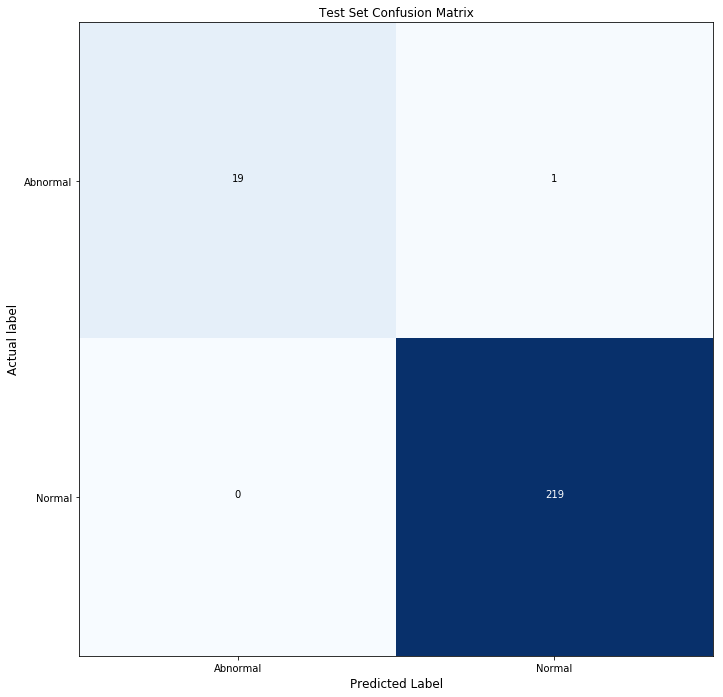

In [11]:
show cnfM:.ml.cfm[dict1[`ytest];pred1]
.ml.displayCM[value cnfM;`Abnormal`Normal;"Test Set Confusion Matrix";()]

### Conclusions

In conclusion it can be seen from multiple runs of the random forest classifiers for different seedings and different splits of the dataset that the use of the feature extraction and significance procedures implemented in this library have improved the ability to predict the normality or otherwise of the wafers produced during the manufacturing process.

The accuracy in the case of using the FreshQ library produces consistently better more accurate results than the benchmark set as the average value being used for the prediction and significantly better results than the naive case where we assume that all wafers produced are fit for further down line use.

This gives an insight into the potential for the use of this form of analysis to be used in the manufacturing sector particularly given the large volumes of data consistently recorded in modern manufacturing processes.

It also offers the potential for reductions in redundant labour and manufacturing procedures thus reducing overall costs in the manufacturing pipeline

---